# Tarea 2: Crea datos mínimos de validación y entrenamiento
Importa bibliotecas Python y establece variables de entorno:

In [1]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]
REGION = 'us-central1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:3]

Exporta archivos que contengan los datos de entrenamiento y validación
Cuando se inicia el lab, se crean algunas tablas en el conjunto de datos de BigQuery. En esta sección, usarás BigQuery para crear tablas temporales en la plataforma que contengan los datos necesarios y, luego, exportarás las tablas a archivos CSV en Google Cloud Storage. Después, deberás borrar la tabla temporal. Más adelante, tendrás que leer y procesar esos archivos de datos CSV a fin de crear los conjuntos de datos completo, de entrenamiento y de validación que necesitas para un modelo de TensorFlow personalizado.

Crea el conjunto de datos de entrenamiento flights_train_data para entrenar el modelo:


In [2]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'True'

Query is running:   0%|          |

""


Crea el conjunto de datos de evaluación flights_eval_data para evaluar el modelo:

In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False AND
  is_train_day = 'False'

Query is running:   0%|          |

""


Crea el conjunto de datos completo flights_all_data con el siguiente código:


In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS
SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND 
  f.DIVERTED = False

Query is running:   0%|          |

""


Exporta los conjuntos de datos completo, de entrenamiento y de validación en formato de archivo CSV al bucket de Google Cloud Storage:  

Este proceso tardará unos 2 minutos en completarse.

Espera hasta que recibas el resultado de la ejecución de la siguiente secuencia de comandos de Bash en la celda del notebook:

In [5]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/train.csv and deleting table
Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/eval.csv and deleting table
Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/all.csv and deleting table


Waiting on bqjob_r9392c8693750d6_00000186d1428b2c_1 ... (65s) Current status: DONE   
Waiting on bqjob_r4702eda363d62127_00000186d1439d30_1 ... (23s) Current status: DONE   
Waiting on bqjob_r685979e114ec042c_00000186d1440962_1 ... (85s) Current status: DONE   


# Tarea 3: Crea los datos de entrada
Configuración en el notebook
Con fines de desarrollo, entrena el modelo por algunos ciclos de entrenamiento. Por eso los NUM_EXAMPLES son tan bajos.

Genera una lista de los objetos exportados en el bucket de Google Cloud Storage con el siguiente código:


In [6]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2023-03-11T15:23:45Z  gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/all.csv
115.19 MiB  2023-03-11T15:22:13Z  gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/eval.csv
296.96 MiB  2023-03-11T15:21:39Z  gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


Con fines de desarrollo, entrena el modelo por algunos ciclos de entrenamiento. Por eso los NUM_EXAMPLES son tan bajos.


In [7]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

Asigna el URI de tus datos de entrenamiento y validación a training_data_uri y validation_data_uri, respectivamente:


In [9]:
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

Configura los parámetros del modelo con el siguiente bloque de código:


In [10]:
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

## Cómo leer datos en TensorFlow

Para leer los archivos CSV desde Google Cloud Storage en TensorFlow, usa un método desde el paquete tf.data:

In [11]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2023-03-11 15:27:11.106542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-11 15:27:11.106595: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-11 15:27:11.106629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow): /proc/driver/nvidia/version does not exist
2023-03-11 15:27:11.109608: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 15:27

0 {'ontime': array([1, 1, 1, 1, 1], dtype=int32), 'dep_delay': array([16,  0, -7, -8, -4], dtype=int32), 'taxi_out': array([15, 17,  9, 18, 13], dtype=int32), 'distance': array([ 991, 2079,  216,  284, 1542], dtype=int32), 'origin': array([b'DEN', b'DTW', b'HNL', b'DTW', b'ANC'], dtype=object), 'dest': array([b'PDX', b'SFO', b'ITO', b'CIU', b'PDX'], dtype=object), 'dep_hour': array([22, 12, 15, 23, 19], dtype=int32), 'is_weekday': array([1, 1, 0, 1, 1], dtype=int32), 'carrier': array([b'UA', b'DL', b'HA', b'OO', b'AS'], dtype=object), 'dep_airport_lat': array([39.861668, 42.2125  , 21.317778, 42.2125  , 61.174168],
      dtype=float32), 'dep_airport_lon': array([-104.67306,  -83.35333, -157.92027,  -83.35333, -149.99806],
      dtype=float32), 'arr_airport_lat': array([45.58861 , 37.61889 , 19.720278, 46.25083 , 45.58861 ],
      dtype=float32), 'arr_airport_lon': array([-122.59695, -122.375  , -155.04834,  -84.4725 , -122.59695],
      dtype=float32)}
1 {'ontime': array([0, 1, 1, 1, 1

Escribe funciones features_and_labels() y read_dataset(). La función read_dataset() lee los datos de entrenamiento, genera ejemplos de batch_size cada vez que lo hace y te permite detener las iteraciones cuando se haya leído una cantidad determinada de ejemplos.

El conjunto de datos contiene todas las columnas del archivo CSV, denominadas según la línea de encabezado. Estos datos están conformados por atributos y la etiqueta. Es mejor separarlos escribiendo la función features_and_labels() para que el código posterior sea más fácil de leer. Por lo tanto, aplicaremos una función pop() al diccionario y mostraremos una tupla de funciones y etiquetas.

Ingresa y ejecuta el siguiente código:

In [12]:
def features_and_labels(features):
  label = features.pop('ontime') 
  return features, label
def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset
if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([52,  2], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([11,  8], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 224, 2583], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'SEA', b'FLL'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'GEG', b'SFO'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([ 5, 21], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'OO', b'VX'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([47.45  , 26.0725], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-122.31167,  -80.15278], dtype=float32)>), ('arr_a

# Tarea 4: Crea, entrena y evalúa el modelo de TensorFlow

Por lo general, debes crear un atributo para cada columna de los datos tabulares. Keras es compatible con las columnas de atributos, lo que permite representar datos estructurados con técnicas de ingeniería de atributos estándar, como la incorporación, el agrupamiento en buckets y las combinaciones de atributos. Ya que los datos numéricos pueden pasarse directamente al modelo de AA, debes mantener las columnas con valores reales separadas de las columnas dispersas (o de string).

Ingresa y ejecuta el siguiente código:

In [13]:
import tensorflow as tf
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

Todos estos atributos provienen directamente del archivo de entrada (y los proporciona cualquier cliente que quiera una predicción para un vuelo). Las capas de entrada tienen correspondencia 1:1 con los atributos de entrada y sus tipos, así que en lugar de repetir los nombres de las columnas, debes crear una capa de entrada para cada una de estas columnas y especificar el tipo de datos correcto (un número de punto flotante o una string).

Ingresa y ejecuta el siguiente código:

In [14]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string') 
          for colname in sparse.keys()
})

## Agrupamiento 

Las columnas con valores reales cuya precisión es excesiva (por lo tanto, es probable que cause sobreajuste) pueden discretizarse y convertirse en columnas categóricas. Por ejemplo, si tienes una columna para la antigüedad del avión, puedes discretizarla en simplemente tres grupos: menos de 5 años de antigüedad, entre 5 y 20 años de antigüedad y más de 20 años de antigüedad. Puedes usar el atajo de discretización para discretizar las latitudes y longitudes, y combinar los buckets. Esto genera el desglose del país en cuadrículas, y se obtiene el punto de cuadrícula en que se ubican una latitud y longitud específicas.

Ingresa y ejecuta el siguiente código:

In [15]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets) 
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets) 
          for key in ['dep_airport_lon', 'arr_airport_lon']
})
# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)
# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)
# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}
if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


## Entrena y evalúa el modelo

Guarda el punto de control:

In [17]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model


Borra los puntos de control del modelo que ya se encuentran en el bucket de almacenamiento con el siguiente código:

In [18]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


Este comando mostrará un error que indica CommandException: 1 files/objects could not be removed porque aún no se ha guardado el modelo. El error indica que no hay archivos en la ubicación de destino. Debes asegurarte de que la ubicación esté vacía antes de intentar guardar el modelo; esto es lo que nos garantiza este comando.

Ahora que las columnas de atributos reales y dispersas se mejoraron más allá de las entradas sin procesar, puedes crear un wide_and_deep_classifier pasando las columnas de atributos profundas y lineales de manera separada:


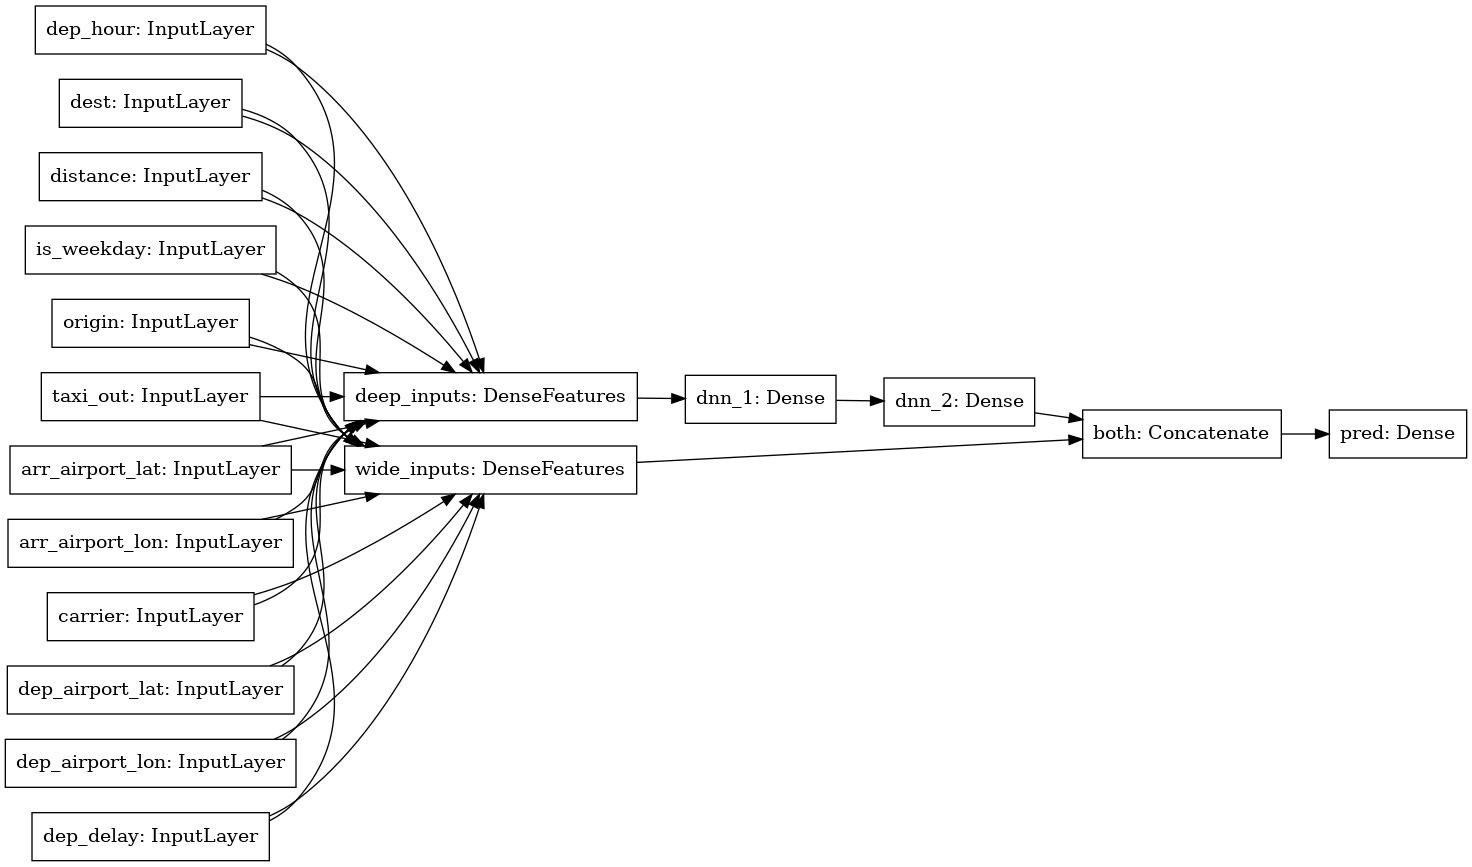

In [19]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

Usa train_dataset para el entrenamiento del modelo, y eval_dataset para su evaluación.

Crea el modelo con los siguientes bloques de código:


In [20]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)
checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_dataset, 
                    validation_data=eval_dataset,
                    epochs=epochs, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
3/3 [==============================] - 13s 4s/step - loss: 0.9806 - accuracy: 0.7656 - val_loss: 0.6213 - val_accuracy: 0.7382

Epoch 00001: saving model to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/checkpoints/flights.cpt
Epoch 2/2
3/3 [==============================] - 10s 5s/step - loss: 0.6562 - accuracy: 0.6771 - val_loss: 0.5118 - val_accuracy: 0.8294

Epoch 00002: saving model to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/checkpoints/flights.cpt


Visualiza la pérdida y la exactitud del modelo con matplotlib.pyplot:


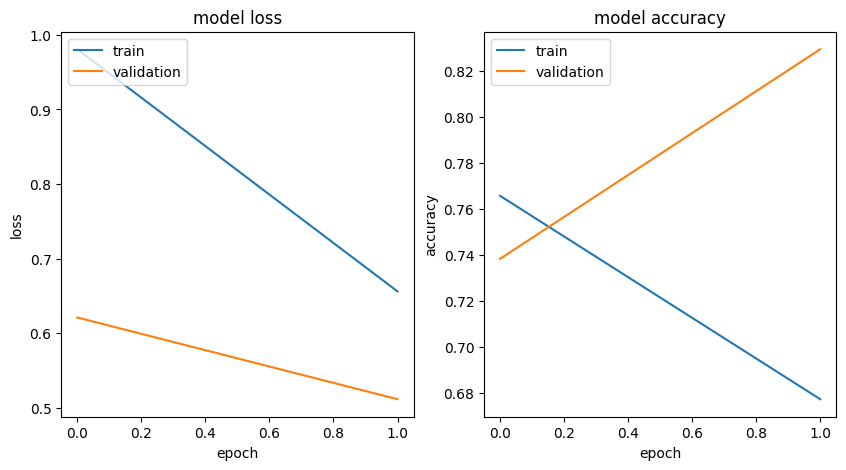

In [21]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))
for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Exporta el modelo entrenado

Guarda los artefactos del modelo en el bucket de Google Cloud Storage:

In [22]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/export/flights_20230311-153252


2023-03-11 15:32:54.972221: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/export/flights_20230311-153252/assets


# Implementa el modelo de vuelos en Vertex AI

Vertex AI proporciona un entorno completamente administrado, con ajuste de escala automático y sin servidores para los modelos de aprendizaje automático. Obtienes los beneficios de pagar por cualquier recurso de procesamiento (como las CPUs o GPU) solo cuando lo usas. Debido a que los modelos se alojan en contenedores, no tienes que preocuparte por la administración de dependencias. Los extremos se encargan de las divisiones del tráfico, lo que te permite realizar pruebas A/B de forma conveniente.

Los beneficios no se limitan solo a no tener que administrar la infraestructura. Después de que implementes el modelo en Vertex AI, obtendrás muchas funciones interesantes sin código adicional, como la explicabilidad, la detección de desvíos, la supervisión y mucho más.

Crea el extremo de modelo flights con la siguiente celda de código y borra los modelos existentes que tienen el mismo nombre:

Nota: El proceso de creación del modelo y del extremo del modelo, y de implementación del modelo en el extremo tardará entre 15 y 20 minutos.  


Nota: En ocasiones, puede producirse un error aproximadamente 5 minutos después de que se inicie este proceso. Si encuentras un error de compilación del modelo, por ejemplo, que la cuenta de servicio no tiene los permisos suficientes para escribir objetos en el bucket de Google Cloud Storage, vuelve a ejecutar la celda de código. Además, debes habilitar la API de Vertex AI si no está habilitada.

In [24]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# create the model using the parameters docker conatiner image and artifact uri
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

Process is terminated.


Crea un archivo de entrada de prueba example_input.json con el siguiente código:

In [26]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Overwriting example_input.json


Realiza una predicción desde el extremo del modelo. Aquí tienes los datos de entrada en un archivo JSON llamado example_input.json:

In [27]:
%%bash
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud beta ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

3313677357465731072
[[0.463921219], [0.334178329]]


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-prediction-aiplatform.googleapis.com/]


Esta es la forma en que los programas cliente pueden invocar el modelo que implementaste.

Da por sentado que tienen los datos de entrada en un archivo JSON llamado example_input.json.

Ahora, envía una solicitud POST de HTTP y obtendrás el resultado en formato JSON:


# Explicabilidad del modelo

La explicabilidad del modelo es uno de los problemas más importantes en el aprendizaje automático. Es un concepto amplio relacionado con el análisis y la comprensión de los resultados que proporcionan los modelos de aprendizaje automático. La explicabilidad en el aprendizaje automático significa que puedes explicar lo que sucede en tu modelo desde la entrada hasta el resultado. Hace que el modelo sea transparente y resuelve el problema de la caja negra. Explainable AI (XAI) es la manera más formal de describir este concepto.

Ejecuta el siguiente código:

In [28]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/export/flights_20230311-153252/
The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_

Crea un archivo JSON explanation-metadata.json que contenga los metadatos que describen la entrada y el resultado del modelo para explicarlos. Aquí, usarás el método sampled-shapley que se utiliza para la explicación:


In [29]:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)} 
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


Visualiza el archivo explanation-metadata.json mediante el comando cat:


In [30]:
!cat explanation-metadata.json

{
  "inputs": {
    "dep_delay": {
      "inputTensorName": "dep_delay"
    },
    "taxi_out": {
      "inputTensorName": "taxi_out"
    },
    "distance": {
      "inputTensorName": "distance"
    },
    "dep_hour": {
      "inputTensorName": "dep_hour"
    },
    "is_weekday": {
      "inputTensorName": "is_weekday"
    },
    "dep_airport_lat": {
      "inputTensorName": "dep_airport_lat"
    },
    "dep_airport_lon": {
      "inputTensorName": "dep_airport_lon"
    },
    "arr_airport_lat": {
      "inputTensorName": "arr_airport_lat"
    },
    "arr_airport_lon": {
      "inputTensorName": "arr_airport_lon"
    },
    "carrier": {
      "inputTensorName": "carrier"
    },
    "origin": {
      "inputTensorName": "origin"
    },
    "dest": {
      "inputTensorName": "dest"
    }
  },
  "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}

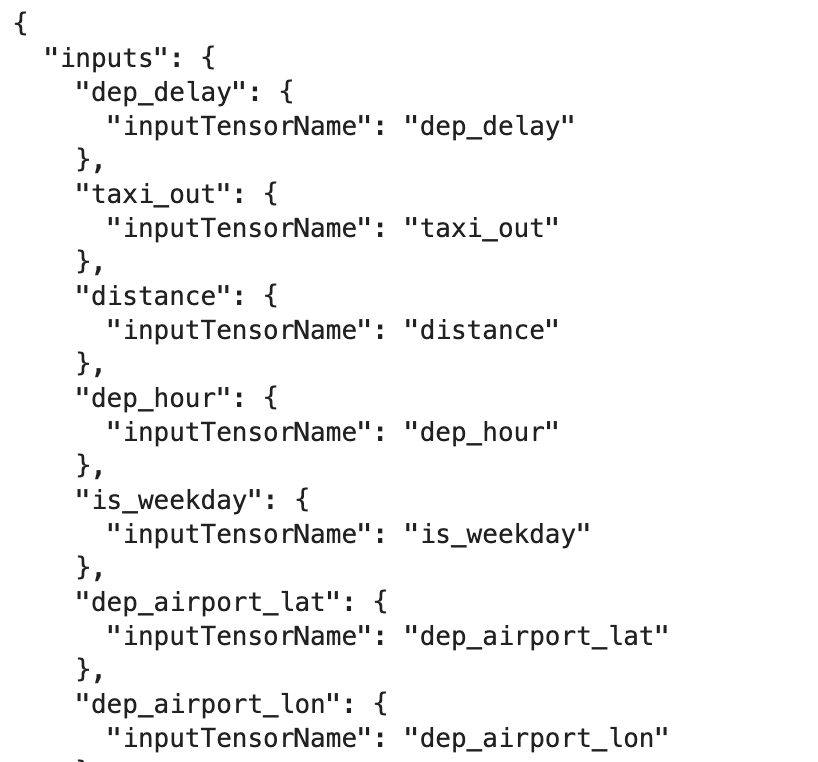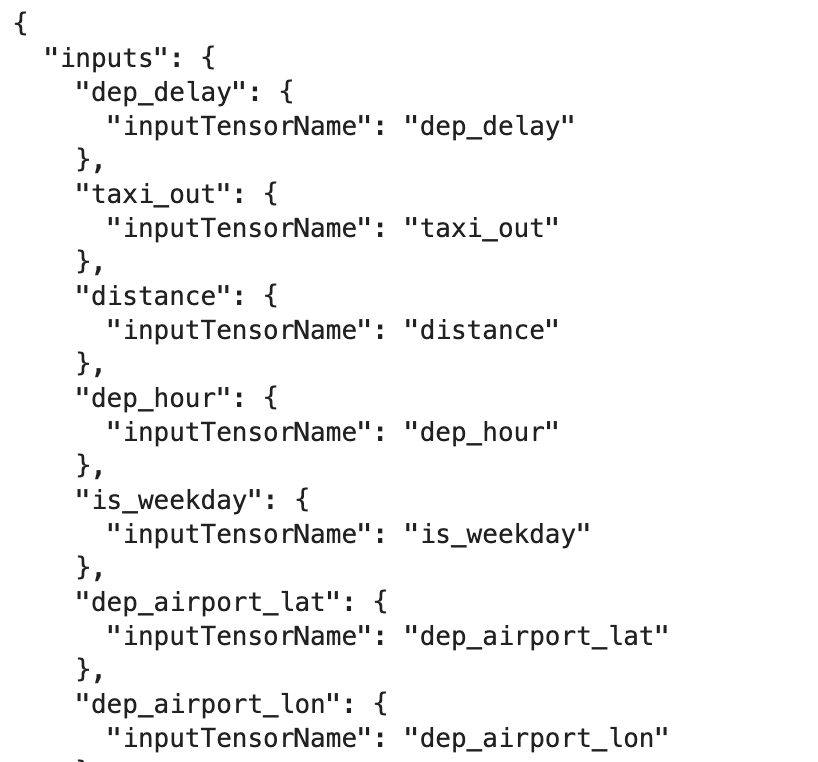

Crea otro modelo flights_xai y, luego, impleméntalo en Vertex AI  

Crea el extremo de modelo flights_xai, sube el modelo y, luego, impleméntalo en el extremo mediante el siguiente código:


In [31]:
%%bash
# note TF_VERSION set in 1st cell, but ENDPOINT_NAME is being changed
# TF_VERSION=2-6
ENDPOINT_NAME=flights_xai
TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH
# create the model endpoint for deploying the model
if [[ $(gcloud beta ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud beta ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"
# delete any existing models with this name
for MODEL_ID in $(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done
# upload the model using the parameters docker conatiner image, artifact URI, explanation method, 
# explanation path count and explanation metadata JSON file `explanation-metadata.json`. 
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud beta ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud beta ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"
# deploy the model to the endpoint
gcloud beta ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=n1-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-03-b1748391dfbc-dsongcp/ch9/trained_model/export/flights_20230311-153252/
Creating Endpoint for flights_xai-20230311-155553
ENDPOINT_ID=891866657847246848
MODEL_ID=4587674883500015616


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2603416829019815936]...
......done.
Created Vertex AI endpoint: projects/222868546452/locations/us-central1/endpoints/891866657847246848.
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [1747732899819421696]...
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# Invoca el modelo implementado

Esta es la forma en que los programas cliente pueden invocar el modelo que implementaste. Da por sentado que tienen los datos de entrada en un archivo JSON llamado example_input.json. Ahora, envía una solicitud POST de HTTP y obtendrás el resultado en formato JSON.

Ejecuta el siguiente código:

In [32]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud beta ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

{
  "error": {
    "code": 400,
    "message": "\"Explainability failed with exception: Exceeded max_retries (5) while Explainer attempting to call Predictor. Error: \u003c_InactiveRpcError of RPC that terminated with:\\n\\tstatus = StatusCode.RESOURCE_EXHAUSTED\\n\\tdetails = \\\"\\\"\\n\\tdebug_error_string = \\\"UNKNOWN:Error received from peer ipv4:10.104.10.2:8500 {grpc_message:\\\"\\\", grpc_status:8, created_time:\\\"2023-03-11T16:10:28.343525191+00:00\\\"}\\\"\\n\u003e\"\n",
    "status": "FAILED_PRECONDITION"
  }
}


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1073    0   530  100   543    146    149  0:00:03  0:00:03 --:--:--   295


¡Felicitaciones!  

Exploraste el enfoque de aprendizaje automático mediante la biblioteca de TensorFlow para realizar un entrenamiento acelerado por GPU. TensorFlow también permite a los científicos informáticos programar en el nivel más bajo que necesiten, motivo por el que muchas innovaciones de investigaciones sobre aprendizaje automático se implementan en TensorFlow. TensorFlow permite a los profesionales del aprendizaje automático usar investigaciones innovadoras sobre AA poco después de su publicación, por lo que no tienen que esperar a que se reimplementen en otro framework. Por último, TensorFlow es portátil a través de una amplia variedad de plataformas de hardware, por lo que con su uso puedes implementar fácilmente el modelo en tus canalizaciones de datos, independientemente del lugar en que se ejecuten.

Entrenaste un modelo de regresión logística con todos los valores de entrada y descubriste que el modelo era incapaz de utilizar eficazmente los atributos nuevos, como las ubicaciones de aeropuertos.

Finaliza tu Quest
Este lab de autoaprendizaje forma parte de la Quest Data Science on Google Cloud: Machine Learning. Una Quest es una serie de labs relacionados que forman una ruta de aprendizaje. Si completas esta Quest, obtendrás una insignia como reconocimiento por tu logro. Puedes hacer públicas tus insignias y agregar vínculos a ellas en tu currículum en línea o en tus cuentas de redes sociales. Inscríbete en cualquier Quest que contenga este lab y obtén un crédito inmediato de finalización. Consulta el catálogo de Google Cloud Skills Boost para ver todas las Quests disponibles.

Realiza tu próximo lab
Continúa la Quest con MLOps con Vertex AI o Aprendizaje automático en tiempo real con Cloud Dataflow y Vertex AI.

Próximos pasos y más información
Data Science on the Google Cloud Platform, 2nd Edition: O'Reilly Media, Inc.
Google Cloud Training & Certification
Aproveche al máximo las tecnologías de Google Cloud. Nuestras clases incluyen habilidades técnicas y recomendaciones para ayudarlo a ponerse en marcha rápidamente y a seguir aprendiendo. Para que pueda realizar nuestros cursos cuando más le convenga, ofrecemos distintos tipos de capacitación de nivel básico a avanzado: según demanda, presenciales y virtuales. Las certificaciones lo ayudan a validar y demostrar sus habilidades y experiencia en las tecnologías de Google Cloud.

Última actualización del manual: 5 de octubre de 2022

Prueba más reciente del lab: 19 de octubre de 2022

Copyright 2020 Google LLC. All rights reserved. Google y el logotipo de Google son marcas de Google LLC. Los demás nombres de productos y empresas pueden ser marcas de las respectivas empresas a las que estén asociados.